## Part II of the data analysis of scraped Rental listings data

## As we saw in the data_analysis.ipynb (ie, the Part 1), we saw mediocre predictions at best, with fairly high RMSEs of $680-$750+, even after removing extreme outliers with respect to rental price. 

## As some additional visualization and sample stats of sqft and # of bathrooms showed, there are still some clear outliers, at least some of which can be attributed to data entry errors. 

### Import the full dataset (ie, from the rental table), examine the sqft data more closely, and remove sqft data that is either too low or too high to be realistic or even possible. 

### Then, proceed with the various data cleaning and transformations we performed in the Part 1 notebook, and finally run the various panel regressions once more. Estimate RMSE and SI, and we should notice some amount of improvement in our predictions.

## Library imports, and data query:

In [1]:
# library imports
# imports:
# file processing
import os
import glob

# data analysis libraries & SQL libraries
import numpy as np
import pandas as pd
# SQL ODBC for API connection between Python & SQL Server
import pyodbc
import sqlalchemy as sa

# data visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import json

# statistical and ML modeling and hypothesis testing libraries
from sklearn.model_selection import KFold   # k-fold cross validation
from sklearn.model_selection import train_test_split  # split datasets into training & test datasets
from sklearn import linear_model  # OLS 
from sklearn import ensemble  # ensemble module contains the GradientBoostingRegressor class, which is used to estimate Gradient-boosted regression models

from sklearn.metrics import mean_squared_error  # calculate MSE to estimate accuracy of regression models 


In [3]:
# import data from rental table
class SQL_Database():
    def __init__(self, sql_config_path):

        with open(sql_config_path, 'r') as fh:
            config = json.load(fh)

        self.driver = config['driver']
        self.server = config['server']
        self.database = config['database']
        self.username = config['username']
        self.password = config['password']
        print(f"Name of connected database:\n{self.database}")


    def import_SQL_to_df(self, sql_query):
        """Import dataset by using SQL query and Pandas' read_sql() method"""
        conn = pyodbc.connect(
            f'DRIVER={self.driver};'
            f'SERVER={self.server};'
            f'DATABASE={self.database};'
            f'UID={self.username};'
            f'PWD={self.password};'
            'Trusted_Connection=yes;'
        )

        # establish connection to SQL Server database, by passing in the database name, etc., using a with statement so it will automatically close the connection & cursor once the with statement has completed execution:
        # initialize cursor so we can execute SQL code
        cursor = conn.cursor() 

        # query to select all records where price > $100, since such a price is essentially impossible and likely a typo from the original scraped rental listing
        # specify SQL query
        sql = sql_query 

        # export SQL query results to Pandas' DataFrame
        df = pd.read_sql(sql,conn)  # export results of SQL query to Pandas' DataFrame

        cursor.close()
        conn.close()
        return df


## import data with no sqft nu+lls and price >$1, via SQL query to Pandas' df
# specify path to json file containing SQL configuration/username data
sql_config_path = "D:\\Coding and Code projects\\Python\\craigslist_data_proj\\CraigslistWebScraper\\SQL_config\\config.json" 

SQL_db = SQL_Database(sql_config_path)  # NB: be sure to pass in path to the json SQL configuration file so we can load in the needed username, password, and configuration data to be able to access the SQL database

# specify query for data selection
query = """SELECT * FROM rental WHERE price > 100 AND region = 'sfbay';"""
# import data to DataFrame via SQL query and Pandas' read_sql() method
df = SQL_db.import_SQL_to_df(query)
df.info() # sanity check

Name of connected database:
craigslist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17956 entries, 0 to 17955
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   listing_id               17956 non-null  int64         
 1   sqft                     17956 non-null  int64         
 2   city                     17956 non-null  object        
 3   price                    17956 non-null  int64         
 4   bedrooms                 17956 non-null  int64         
 5   bathrooms                17956 non-null  float64       
 6   attr_vars                17956 non-null  object        
 7   date_of_webcrawler       17956 non-null  datetime64[ns]
 8   kitchen                  17956 non-null  int64         
 9   date_posted              17956 non-null  datetime64[ns]
 10  region                   17956 non-null  object        
 11  sub_region               17956 non-null  object       

## Examine sqft sample stats, and values for sqft that are very likely unreasonably high--e.g., sqft > 10k:

In [4]:
# sqft sample stats
df[['price', 'sqft']].describe()

,price,sqft
count,17956.000000,1.795600e+04
mean,2891.801014,8.508766e+03
std,1090.946491,1.272609e+04
min,200.000000,1.000000e+00
25%,2200.000000,6.150000e+03
50%,2683.500000,8.000000e+03
75%,3323.000000,1.018000e+04
max,12000.000000,1.080000e+06


### The sqft distribution indicates that there are min & max values that are unreasonably too low or high.

### Let's examine absurdly high & low ranges of sqft:

In [5]:
# listings stated as having sqft > 10,000: 
df.loc[df['sqft'] > 10000][['price','in_law_apt', 'sqft', 'apt', 'bedrooms', 'bathrooms']]

,price,in_law_apt,sqft,apt,bedrooms,bathrooms
2,3550,0,6500,1,1,1.0
3,4395,0,6500,1,2,2.0
4,1750,1,6560,0,1,1.0
5,3300,0,9500,1,2,2.0
6,3300,0,5210,1,2,2.0
...,...,...,...,...,...,...
17950,1595,0,8000,1,0,1.0
17951,1817,0,5520,0,1,1.0
17952,1500,1,3000,0,1,1.0
17954,1300,0,7360,1,1,1.0


In [6]:
# show some data for listings stated as having sqft < 100: 
df.loc[df['sqft'] < 100][['price','in_law_apt', 'sqft', 'apt', 'bedrooms', 'bathrooms']]

,price,in_law_apt,sqft,apt,bedrooms,bathrooms
2761,3075,0,10,0,1,1.0
5676,1045,0,90,1,0,1.0
6112,2100,0,1,0,1,1.0
6572,1045,0,90,1,0,1.0
7264,1095,0,90,1,1,1.0
7508,1200,0,85,0,1,1.0
7577,1045,0,90,1,0,1.0
7629,1095,0,90,1,1,1.0
7636,1045,0,90,1,0,1.0
7742,1045,0,90,1,0,1.0


## Discussing sqft outliers: 

### Notice there are *extremely* high sqft outliers, with sqft > 20k and even as high as 90k+. This accounts for the sample standard deviation being quite a bit higher than even the mean!

### In addition, on the left tail of the distribution, there are also listings stated as having absurdly low sqft values, such as 1, 10, or 15 sqft. 

### As a result, we should remove sqft values on both extremes of the distribution: namely, remove listings that are (likely incorrectly) stated as having a) sqft > 10,000 or b) sqft < 100.   

### . This approach is more useful in our case than removing outliers based on interquartile range (IQR) merely because of how extraordinarily skewed the distribution is. If we removed outliers merely using the IQR approach, we would likely still have some sqft values that lie within the 2 extremes we've identified above. As a result, we will instead use our own custom-specified ranges. 

### Remove sqft outliers that we've specified--namely: a) sqft > 10,000 or b) sqft < 100:

In [5]:
# remove listings that are very likely posted with incorrect number of bedrooms
def delete_listings_with_suspicious_sqft_vals(df):
    """Remove listings that have suspiciously or even iompossibly high or low sqft values.
    Namely: a) sqft > 10k or b) sqft < 100"""
    # remove listings with suspicious sqft vals:  
    return df.loc[~((df.sqft>10000) | (df.sqft < 100)) ]  # remove any rows with sqft > 10k or sqft <100

# filter data based on sqft:
df = delete_listings_with_suspicious_sqft_vals(df)

# sanity check
print(f'Having cleaned the data, the new min and max sqft values are: {df.sqft.min()} & {df.sqft.max()}')  

Having cleaned the data, the new min and max sqft values are: 100 & 10000


### Let's examine the data a bit closer now that we've cleaned the data wrt sqft a bit. 

### Boxplot of sqft

<AxesSubplot:xlabel='sqft'>

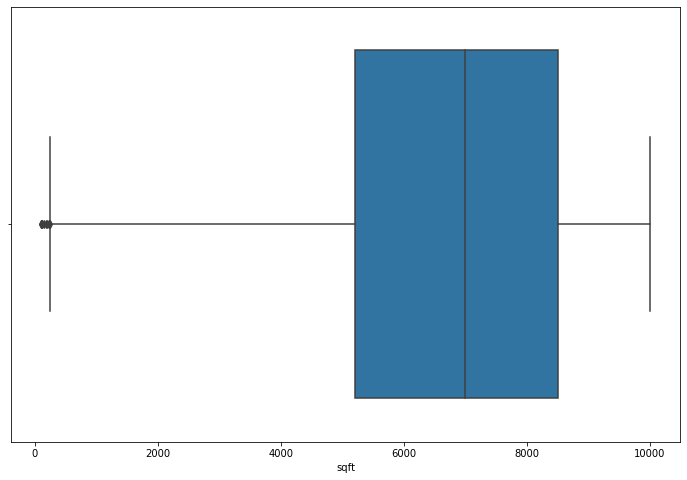

In [45]:
def boxplot_with_y_var_and_hue(df, x_axis_var:str, y_axis_var:str, hue_option:str, custom_palette:dict):
    if hue_option is not None:        
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var, hue=hue_option, palette= custom_palette)
    else:  # ie, if we do *not* want to use a hue
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var)

# sqft
boxplot_with_y_var_and_hue(df, 'sqft', None, None, None)

### Cleaned distribution of sqft?: Notice the distribution of sqft now is much less skewed, with only a relative few outliers on the left side of the distribution and none whatsoever on the right side.

### While a sqft of 100 is very low, it's not necessarily impossible, especially for studio apartment listings.

### Next, Implement boxplot of bedrooms and price:

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

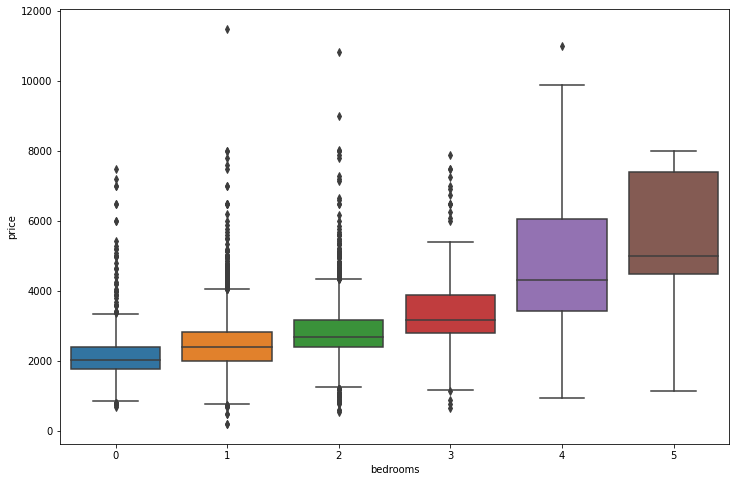

In [33]:
def boxplot_with_y_var_and_hue(df, x_axis_var:str, y_axis_var:str, hue_option:str, custom_palette:dict):
    if hue_option is not None:        
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var, hue=hue_option, palette= custom_palette)
    else:  # ie, if we do *not* want to use a hue
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var)


# prices distribution by # of bedrooms (overall) boxplot
boxplot_with_y_var_and_hue(df, "bedrooms", "price", None, None)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

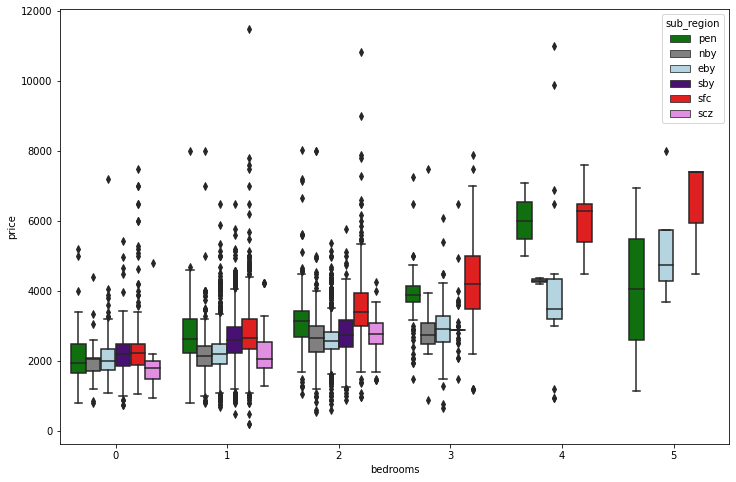

In [77]:
##  boxplot of number of bedrooms by price and sub_region (hue): 

# NB: create a dictionary defining a cutsomized palette of colors to use for each subregion:
subregion_palette = {"nby": "grey", "eby": "lightblue", "pen":"g", "sfc":"red", "sby":"indigo", "scz":"violet"}

hue_op_subregion = "sub_region"

boxplot_with_y_var_and_hue(df, "bedrooms", "price", hue_op_subregion, subregion_palette)

In [43]:
## show mean price by sqft
print("Mean price by sqft:")
df.groupby('sub_region')['price'].mean()  # mean price by sqft

Mean price by sqft:


sub_region
eby    2401.035762
nby    2313.721689
pen    2856.963973
sby    2619.049867
scz    2232.551948
sfc    2872.116561
Name: price, dtype: float64

## Analysis of plots:

### Notice that having removed sqft outliers, it becomes more clear than in our analysis in Part 1 that the the average rental price is actually *slightly* higher in SF than Peninsula, rather than the reverse. 

### When examined by number of bedrooms, this slight difference in average rental prices is driven mostly by studios as well as listings with either 2 or 3 bedrooms. Only 1 bedroom listings are actually more expoensive on average in the Peninsula than SF. South Bay studios, somewhat surprisingly, are actually virtually as expensive as SF studios.

## Next, proceed with *all* of the other data cleaning and transformations that we performed during the part 1 (ie, data_analysis.ipynb) of this analysis:

### 1st, create the various time series-related datetime columns--ie, week, month, etc:

In [6]:
def create_weekday_name_col(df, datetime_col):
    return df[datetime_col].dt.day_name()

# a) day of week (ie, Sunday, Monday, etc.)
df['day_of_week'] = create_weekday_name_col(df, 'date_posted')

def create_week_datetime_col(df, datetime_col):
    return df[datetime_col].dt.week


# b) week over week indicator
df['week'] = create_week_datetime_col(df, 'date_posted')

def create_month_datetime_col(df, datetime_col):
    return df[datetime_col].dt.month


df['month'] = create_month_datetime_col(df, 'date_posted')


def create_year_datetime_col(df, datetime_col):
    return df[datetime_col].dt.year

df['year'] = create_year_datetime_col(df, 'date_posted')


df[['day_of_week', 'week', 'month' , 'year', 'date_posted']] # sanity check

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,day_of_week,week,month,year,date_posted
2,Thursday,36,9,2021,2021-09-09 10:25:00
3,Friday,36,9,2021,2021-09-10 16:06:00
4,Friday,36,9,2021,2021-09-10 22:00:00
5,Saturday,36,9,2021,2021-09-11 21:09:00
6,Sunday,36,9,2021,2021-09-12 22:22:00
...,...,...,...,...,...
17949,Wednesday,10,3,2022,2022-03-09 22:10:00
17950,Wednesday,10,3,2022,2022-03-09 22:12:00
17951,Wednesday,10,3,2022,2022-03-09 22:27:00
17952,Wednesday,10,3,2022,2022-03-09 23:39:00


## Clean data based on high number of bedrooms and low prices:

In [7]:
# remove listings that are very likely posted with incorrect number of bedrooms
def delete_listings_with_incorrect_bedroom_and_price_vals(df):
    """Remove apartment property type that have suspiciously low rental prices and an absurdly high number of bedrooms: namely--6 or more bedrooms."""
    # remove listings that are of apt type, have 6+ bedrooms, and have rental price < $3,500  
    return df.loc[~((df.bedrooms>5) & (df.price < 3500))]

#filter data
df = delete_listings_with_incorrect_bedroom_and_price_vals(df)
# sanity check
df.bedrooms.value_counts()  # NB: there should be fewer listings with > 5 bedrooms  

1    7255
2    4176
0    1254
3     354
4      40
5       9
Name: bedrooms, dtype: int64

### Plot price vs sqft:

<AxesSubplot:xlabel='sqft', ylabel='price'>

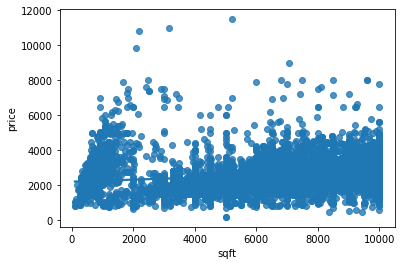

In [50]:
def regplot_seaborn(df, x, y):
    return sns.regplot(x=x, y=y, data=df)


# scatterplot of sqft
regplot_seaborn(df, 'sqft', 'price')

### Notice there is a very slight correlation, even less than before we removed sqft outliers based our rule of sqft needing to be: 10k <= sqft >= 100.


### Transform sqft to log:

In [8]:
# transform sqft to log
def log_transform(df, col_to_transform):
    return np.log(df[col_to_transform])

df['sqft_log'] = log_transform(df, 'sqft')

# sanity check
df['sqft_log']

2        8.779557
3        8.779557
4        8.788746
5        9.159047
6        8.558335
           ...   
17949    8.987197
17950    8.987197
17951    8.616133
17952    8.006368
17954    8.903815
Name: sqft_log, Length: 13088, dtype: float64

## Ensure that each set of indicator variables that are supposed to be mutually exclusive are in fact mutually exclusive (ie, sum of each set of indicator variable per row or record listing must equal a total of 1 at most):

In [9]:
# identify whether any sets of indicator variables are perfectly collinear, anmd remove any indicator variabels that should be mutually exclusive, but are not--ie, sum >=1 for the set of indicator variables for a given rental listing (ie, row)
def identify_perfect_collinearity(df, indicator_var_group_col_names:list, sum_of_indicator_groups_colname):
    """Using a list of all columns within a group of idicator variables, take the .sum() along the rows (ie, axis=1) identify if any rows have a 1 in *more than 1* of the cols by seeing whether the .sum() of the indicator cols along the rows (ie, axis=1) is greater than 1. 
    If this is the case, then the given group of indicator vars is *not* pefectly collinear (even though they theoretically should be)!"""
    # compute sum of given group of indicator var cols along rows (ie, axis=1), and add this sum as new col:
    df[sum_of_indicator_groups_colname] = df[indicator_var_group_col_names].sum(axis=1)  # take sum of group of indicator var cols 

    # see whether any rows (ie, rental listings) have a sum >1 among the group of indicator cols. If so, then *remove* these given rows (rental listings).
    row_filter = df[df[sum_of_indicator_groups_colname] > 1]  # specify filter criteria
    # sanity check
    print(f"The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:\n{row_filter}")
    # remove these problematic rows from dataset, by applying the negation of the filter (ie, with sum <= 1):
    df = df[df[sum_of_indicator_groups_colname] <= 1]
    # remove sum_of_indicator_groups_colname since it's no longer needed
    df = df.drop(columns=[sum_of_indicator_groups_colname])
    return df


# property/home indicator var cols group
housing_type_indicators = ['apt', 'in_law_apt', 'condo', 'townhouse', 'cottage_or_cabin', 'single_fam', 'duplex', 'flat', 'land']


df = identify_perfect_collinearity(df, housing_type_indicators, 'housing_type_row_sum')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
      listing_id  sqft          city  price  bedrooms  bathrooms  \
62    7388669952  9500      Petaluma   2175         2        1.0   
562   7397023232  9900    San Rafael   1995         1        1.0   
567   7397180416  7200    Santa Rosa   1850         1        1.0   
661   7398716416  8500        Novato   2865         2        2.0   
692   7398986240  4400    San Rafael   1950         0        1.0   
698   7399021568  6600    Santa Rosa   2046         1        1.0   
791   7399582208  7520    Santa Rosa   2132         1        1.0   
809   7399651328  6800      Petaluma   2380         1        1.0   
854   7399968256  8350        Novato   2415         2        1.0   
924   7400109056  9500    Santa Rosa   2441         2        1.0   
931   7400120832  9540    San Rafael   3195         2        1.0   
1640  7405201920  5250   

In [10]:
# next, apply filter to laundry indicators

# specify laundry indicator var names
laundry_indicators = ['laundry_in_bldg', 'no_laundry', 'washer_and_dryer', 'washer_and_dryer_hookup', 'laundry_on_site']
 
df = identify_perfect_collinearity(df, laundry_indicators, 'laundry_ind_sum')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
       listing_id  sqft                 city  price  bedrooms  bathrooms  \
37     7386295296  7430            Daly City   1400         0        1.0   
38     7387141632  5000         Walnut Creek   1900         1        1.0   
67     7389036544  4480              Concord   1600         1        1.0   
90     7389910528  1800         Walnut Creek   1400         1        1.0   
102    7390080000  6300  South San Francisco   1650         1        1.0   
...           ...   ...                  ...    ...       ...        ...   
17630  7454707200  5000             San Jose   1825         1        1.0   
17647  7454804992  3130             Campbell   1550         1        1.0   
17689  7455145472  8000             Campbell   1600         1        1.0   
17738  7455324672  4000          Santa Clara   1600         1        1.0   
17952

In [11]:
# flooring type indicators 
flooring_type_indicators = ['flooring_carpet',	'flooring_wood', 'flooring_tile', 'flooring_hardwood', 'flooring_other']

df = identify_perfect_collinearity(df, flooring_type_indicators, 'flooring_types')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
Empty DataFrame
Columns: [listing_id, sqft, city, price, bedrooms, bathrooms, attr_vars, date_of_webcrawler, kitchen, date_posted, region, sub_region, cats_OK, dogs_OK, wheelchair_accessible, laundry_in_bldg, no_laundry, washer_and_dryer, washer_and_dryer_hookup, laundry_on_site, full_kitchen, dishwasher, refrigerator, oven, flooring_carpet, flooring_wood, flooring_tile, flooring_hardwood, flooring_other, apt, in_law_apt, condo, townhouse, cottage_or_cabin, single_fam, duplex, flat, land, is_furnished, attached_garage, detached_garage, carport, off_street_parking, no_parking, EV_charging, air_condition, no_smoking, day_of_week, week, month, year, sqft_log, flooring_types]
Index: []

[0 rows x 53 columns]


In [12]:
# parking options indicators
parking_options_indicators = ['attached_garage','detached_garage', 'carport', 'off_street_parking', 'no_parking']

df = identify_perfect_collinearity(df, parking_options_indicators, 'parking_ops')

The following rows (ie, rental listings) will need to be removed since they violate the assumption of the indicator variable columns being mutually exclusive:
Empty DataFrame
Columns: [listing_id, sqft, city, price, bedrooms, bathrooms, attr_vars, date_of_webcrawler, kitchen, date_posted, region, sub_region, cats_OK, dogs_OK, wheelchair_accessible, laundry_in_bldg, no_laundry, washer_and_dryer, washer_and_dryer_hookup, laundry_on_site, full_kitchen, dishwasher, refrigerator, oven, flooring_carpet, flooring_wood, flooring_tile, flooring_hardwood, flooring_other, apt, in_law_apt, condo, townhouse, cottage_or_cabin, single_fam, duplex, flat, land, is_furnished, attached_garage, detached_garage, carport, off_street_parking, no_parking, EV_charging, air_condition, no_smoking, day_of_week, week, month, year, sqft_log, parking_ops]
Index: []

[0 rows x 53 columns]


#### Having cleaned and removed some rows based on the sets of indicator vars, we might now have some indicator variables that have *only* 0s. 

### Remove columns with only 0s to avoid perfect multicollinearity and save on RAM:


In [13]:
def remove_cols_with_only_0s(df):
    """Remove any columns that have only 0s, since including them 
    in a regression model would result in perfect multicollinearity."""
    df = df.loc[:, (df != 0).any(axis=0)]
    return df

df = remove_cols_with_only_0s(df)

In [14]:
""" Sanity check--the 'land' col should have at least one 1 value, and not comprise just 0s. 
Otherwise, the remove_cols_with_only_0s() function should have removed the entire column"""

def test_land_and_hardwood_col_vals(df):
    if 'land' and 'flooring_hardwood' in df:
        # print value_counts() to verify that there's at least 1 non-zero value 
        print(f'land col value counts:\n{df.land.value_counts()} \n\n')
        print(f'flooring_hardwood col value counts:\n {df.flooring_hardwood.value_counts()}')
    
    elif 'land' not in df and 'flooring_hardwood' in df:
        print("The land col was removed by the remove_cols_with_only_0s() function.\n")
        print(f'flooring_hardwood col value counts:\n{df.flooring_hardwood.value_counts()}')

    elif 'flooring_hardwood' not in df and 'land' in df:
        print("The flooring_hardwood col was removed by the remove_cols_with_only_0s() function.\n")
        print(f'land col value counts:\n{df.land.value_counts()} \n\n')

    else:
        print("The land & flooring_hardwood cols were removed by the remove_cols_with_only_0s() function.")

# apply function to check on values/existence of land col
test_land_and_hardwood_col_vals(df)

The land & flooring_hardwood cols were removed by the remove_cols_with_only_0s() function.


## Heatmap of correlation coefficient matrix:

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


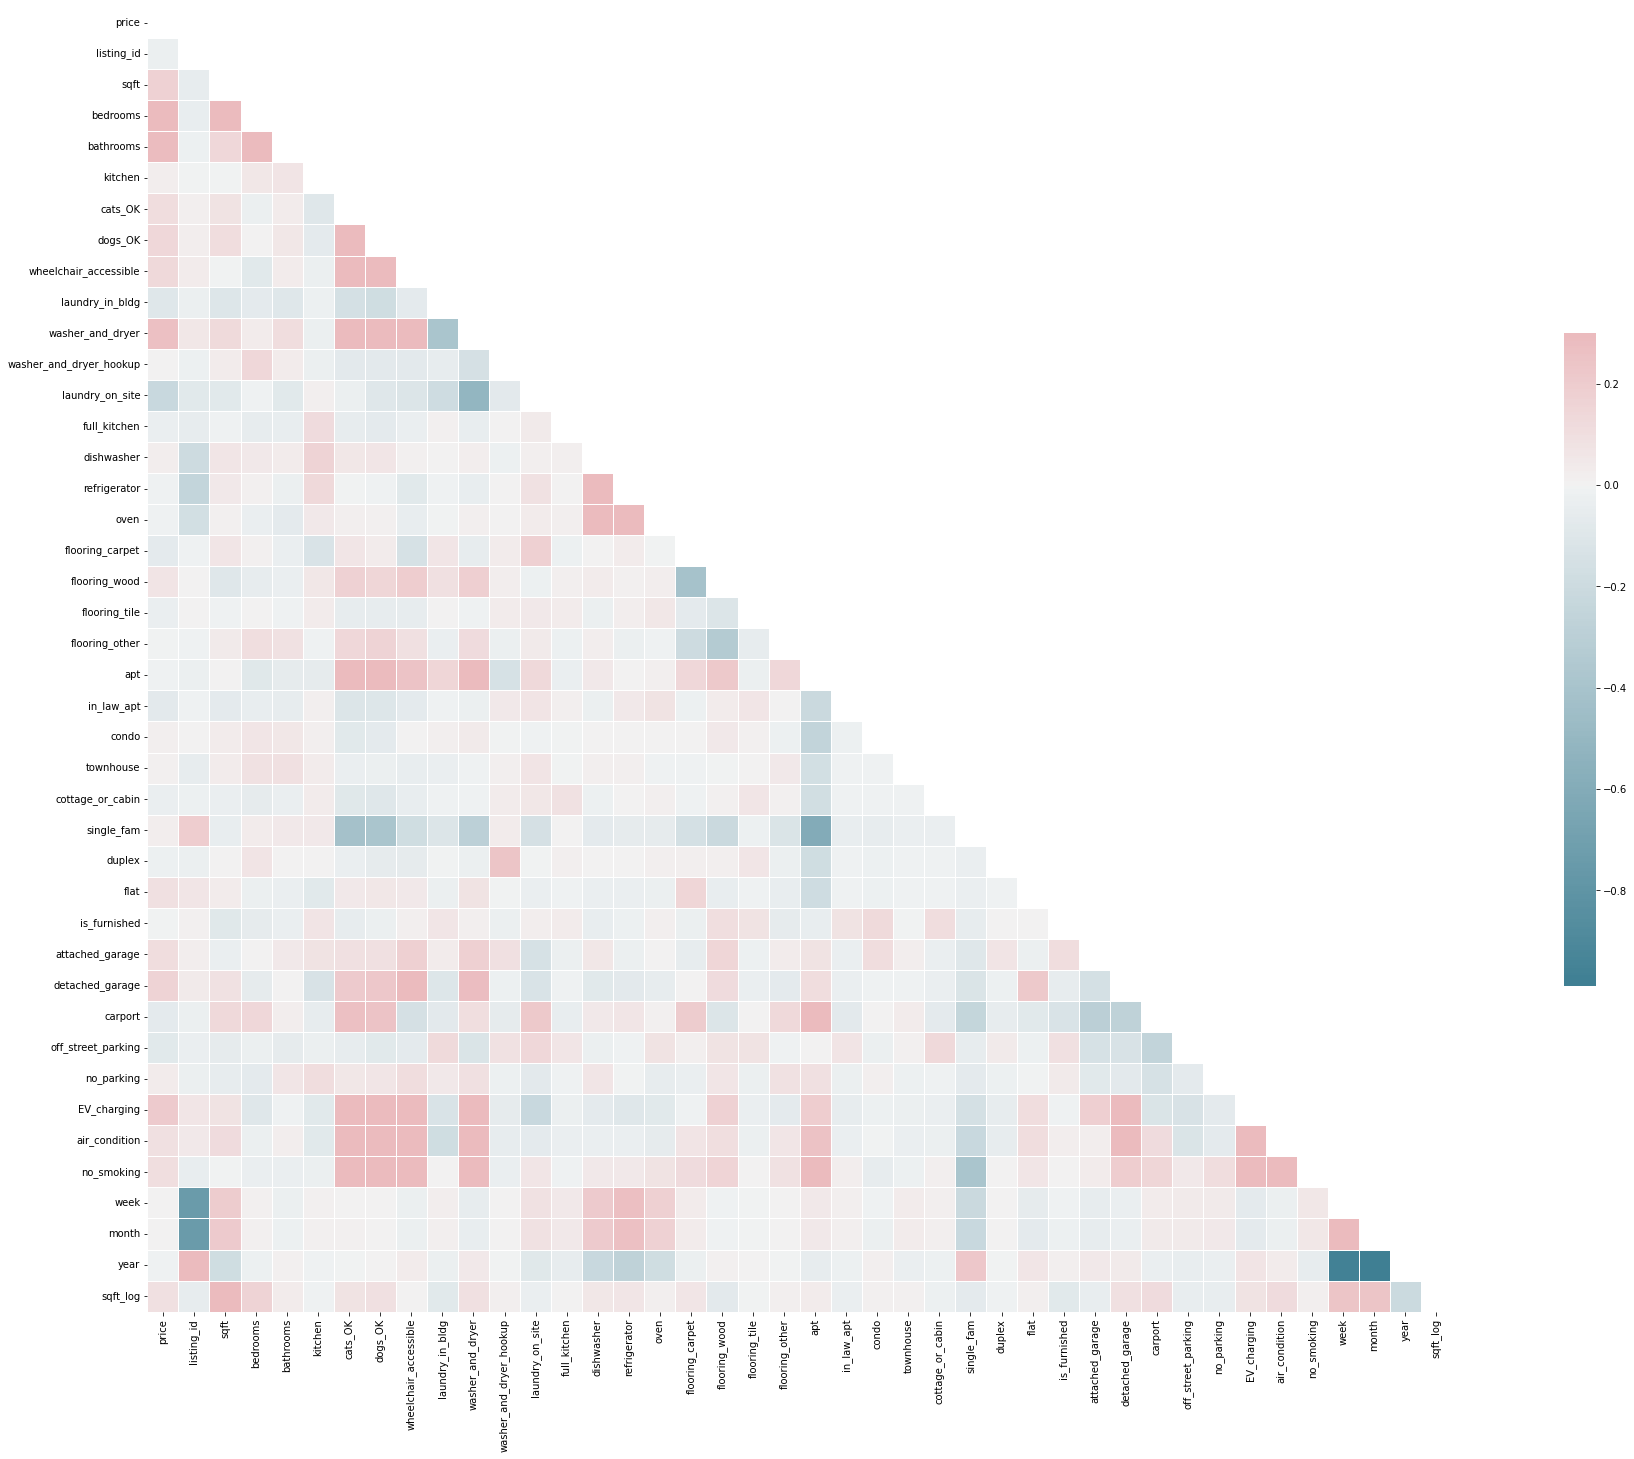

In [61]:
# visualize heatmap of correlation coefficient matrix to analyze correlations between each of the variables within the dataset:
# compute correlation coefficient matrix (but be sure to filter out any non-numeric columns such as cities)
#show heatmap plot of correlation (sort of a heatmap of a correlation matrix)
#calculate the correlations of each variable to price
def corr_heatmap(df, outcome_var):
    # for purposes of finding correlations with price, create a new Index object and convert to list with all numeric (int64 & float) columns from the  dataframe
    # we will exclude all indicator variables (ie, data type of 'uint8') since some have so many groups
    numeric_RHS = df.select_dtypes(include=['int64','float64']).columns  #exclude indicator variables
    #drop the outcome var from this df since we should only include RHS variables for this
    numeric_RHS = numeric_RHS.drop([outcome_var]) 
    #also, convert numeric_RHS to list:
    numeric_RHS_lis  = list(numeric_RHS)
    #calculate correlation of each RHS column with respect to the dependent variable
    corr = df[[outcome_var] + numeric_RHS_lis].corr()
    #Initialize the heatmap plot
    f, ax = plt.subplots(figsize=(40,24))
    #Create a mask to generate an upper triangular shape
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    #Set up a color map with a diverging palette of 3 colors
    cmap= sns.diverging_palette(220,10, as_cmap = True)
    #Notice the plot has a triangular shape, and the levels and intensity of positive and negative correlations are shown with 2 diverging colors.
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws ={"shrink": .5})

#heatmap of correlation coefficient matrix:
corr_heatmap(df, 'price') #NB: For this heatmap, note that a darker red color conveys higher positive correlation, white indicates no correlation, and blue indicates higher negative correlation)


### Other than the number of bedrooms & bathrooms, no variable tends to have much correlation with rental price.

### Even sqft--both linear and especially logarithmic--has only a slight positive correlation, maybe ~10%.


## Examine multicollinearity issues: Estimate VIF 

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


def estimate_VIF(df, outcome_var):
    """Estimate VIF of the various covariates with each other"""
    # exclude outcome variable
    X = df.drop(columns=[outcome_var])  # exclude outcome variable since we are only interested in the RHS variables (examining correlations among each other)
    # NB: drop any time series-related cols such as day of week or month:
    X = X.drop(columns=['day_of_week', 'week', 'month', 'year']) # exclude any datetime-esque numeric cols
    # select only *numeric* columns since we cannot compute VIF for non-numeric data types (ie, object or categorical, etc.)
    X = X.select_dtypes(include=[np.number]) # select only numeric data types
    # add constant (since we are estimating an OLS to derive VIF)
    X = add_constant(X)
    # estimate VIF (for all possible RHS vars):
    VIF = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)  # estimate VIF
    
    return VIF  # return VIF estimate as DataFrame


VIF = estimate_VIF(df, 'price')

# sanity check 
print(f'VIF--ie, measure of multicollinearity:\n{VIF}')

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF--ie, measure of multicollinearity:
const                       0.000000
listing_id                  1.180963
sqft                       11.397290
bedrooms                    1.912892
bathrooms                   1.490066
kitchen                     1.126646
cats_OK                     5.193999
dogs_OK                     5.301331
wheelchair_accessible       1.759890
laundry_in_bldg             7.960048
washer_and_dryer           17.758338
washer_and_dryer_hookup     2.135185
laundry_on_site            11.812369
full_kitchen                1.039814
dishwasher                  1.377405
refrigerator                1.566647
oven                        1.333232
flooring_carpet             2.615169
flooring_wood               3.302223
flooring_tile               1.190535
flooring_other              2.204813
apt                         9.863030
in_law_apt                  1.758281
condo                       2.096110
townhouse                   1.478465
cottage_or_cabin            1.514444

### Most of the variables that have a hgh VIF--namely, VIF > 10--are within the sets of mutually exclusive indicator variables. 

### Since we will remove 1 indicator variable each as *reference groups* for each of these sets of dummy variables, we do not need to remove these variables separetely: e.g., apt, washer_and_dryer, etc.

### Examine week-over-week trends in the data by subregion:

#### Lineplot of week over week subregion price data:

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Week over Week Median Rental Prices By Subregion'}, xlabel='date_posted', ylabel='price'>

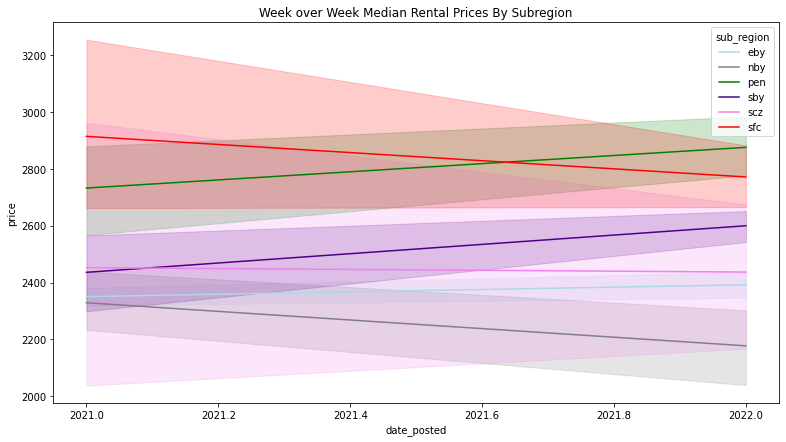

In [78]:
def lineplot_seaborn(figsize_tuple, df, datetime_col, col_y_axis, hue_col_option, color_palette, plot_title):
    plt.figure(figsize=figsize_tuple)  # specify plot's figure size
    pl = sns.lineplot(x=datetime_col, y= col_y_axis, data=df, 
    hue=hue_col_option, palette= color_palette)  
    pl.set(title= plot_title) # specify title
    return pl

lp_title_weekday_median_subreg = "Week over Week Median Rental Prices By Subregion"  # specify plot's title
# use same subregion palette
subregion_palette = {"nby": "grey", "eby": "lightblue", "pen":"g", "sfc":"red", "sby":"indigo", "scz":"violet"}

# group data by week over week,year,  & subregion:
df_subreg_prices_weekly = df.groupby(
    [df['date_posted'].dt.week, df['date_posted'].dt.year, "sub_region"])["price", "bedrooms"].median()
 

lineplot_seaborn((13, 7), df_subreg_prices_weekly, 'date_posted', 'price',  'sub_region',subregion_palette, lp_title_weekday_median_subreg)


## Week over week rental price trends by subregion:

### These trends have changed a bit relative to prior to removing sqft outliers, ie, back in the data_analysis Part 1 analysis.

### Namely, only 2 subregions showed week over week increase in rental prices: the North Bay and, somewhat surprisingly, San Francisco. The other subregions--other than Santa Cruz, whose prices somewhat stagnated--increased moderately or even fairly substantially, particularly the Pneinsula and South Bay.

## Let's double-check the overall distribution of rental price:

<AxesSubplot:xlabel='price'>

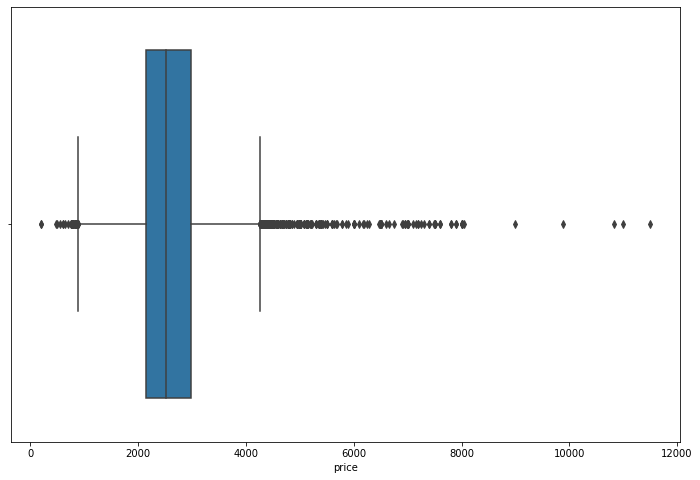

In [16]:
def boxplot_with_y_var_and_hue(df, x_axis_var:str, y_axis_var:str, hue_option:str, custom_palette:dict):
    if hue_option is not None:        
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var, hue=hue_option, palette= custom_palette)
    else:  # ie, if we do *not* want to use a hue
        plt.figure(figsize=(12,8))
        return sns.boxplot(data=df, x=x_axis_var, y= y_axis_var)

# price (overall)
boxplot_with_y_var_and_hue(df, 'price', None, None, None)

### Clearly, there are still large outliers, especially on the extreme right side of the distribution.

### As a result, let's remove outliers based on IQR (interquartile range), let's use 1.5 times IQR as our rule for removing outliers:

In [25]:
## remove outliers

# IQR (Interquartile) range approach for outlier detection--remove extreme outliers:

# calculate 1st & 3rd quartiles, IQR, and then the min and max thresholds based on IQR, etc
def IQR_outlier_detection_and_removal(df, col_with_outliers, iqr_thres=1.5):
    """ 
    Detect outliers based on IQR. Remove outliers based on being 1.5 times above or below Q3 & Q1, respectively.
    Check if input is Series or DataFrame, and apply the function accordingly.  
    """
    import scipy.stats as stats
    # check if input data is a Series object: 
    if isinstance(df, pd.core.series.Series):  # if df is in fact a Pandas' Series
        # calculate the 1st & 3rd quartiles:
        Q1 =  df.quantile(q=.25)  # 1st quartile
        Q3 =  df.quantile(q=.75) # 3rd quartile
        IQR = Q3 - Q1    # calculate interquartile range (ie, IQR)
        min_thres = Q1 - IQR*iqr_thres # define min threshold --namely: subtract Q1 from IQR times 3 (given iqr_thres parameter)
        max_thres = Q3 + IQR*iqr_thres  # define max threshold
        print(f"Q1: {Q1},\n Q3: {Q3}, \n IQR: {IQR}, \n min threshold: {min_thres}, \n max thres: {max_thres}\n") # print Q1, Q2, IQR, and thresholds 
        data_sans_outliers =  df[(df > min_thres) & (df < max_thres)] # remove outliers--ie, above the max threshold OR below the min threshold
        print(f"Number of records in the dataset after removing outliers: \n{data_sans_outliers.shape[0]} \n")

    else:  # if input is a DataFrame
        # calculate the 1st & 3rd quartiles:
        Q1 =  df[col_with_outliers].quantile(q=.25)  #calculate 1st quartile
        Q3 =  df[col_with_outliers].quantile(q=.75) #calculate 3rd quartile
        IQR = Q3 - Q1    # calculate interquartile range (ie, IQR)
        min_thres = Q1 - IQR*iqr_thres # define min threshold --namely: subtract Q1 from IQR times 3 (given iqr_thres parameter)
        max_thres = Q3 + IQR*iqr_thres  # define max threshold
        print(f"Q1: {Q1},\n Q3: {Q3}, \n IQR: {IQR}, \n min threshold: {min_thres}, \n max thres: {max_thres}\n") # print Q1, Q2, IQR, and thresholds 
        data_sans_outliers =  df[(df[col_with_outliers] > min_thres) & (df[col_with_outliers] < max_thres)] # remove outliers--ie, above the max threshold OR below the min threshold
        print(f"Number of records in the dataset after removing outliers: \n{data_sans_outliers.shape[0]} \n")
    
    return data_sans_outliers

#remove outliers via function:
df = IQR_outlier_detection_and_removal(df, 'price')


# sanity check
def check_for_new_min_and_max_after_outlier_removal(df, col_with_outliers):
    if isinstance(df, pd.core.series.Series):  # if df is in fact a Pandas' Series
            print(f"New min & max values for price wrt training dataset (after removing outliers) is:\nmax:{df.max()}\n& min:{df.min()}")
    else:
        print(f"New min & max values for price wrt training dataset (after removing outliers) is:\nmax:{df[col_with_outliers].max()}\n& min:{df[col_with_outliers].min()}")
        
check_for_new_min_and_max_after_outlier_removal(df, 'price')

Q1: 2136.0,
 Q3: 2975.0, 
 IQR: 839.0, 
 min threshold: 877.5, 
 max thres: 4233.5

Number of records in the dataset after removing outliers: 
11977 

New min & max values for price wrt training dataset (after removing outliers) is:
max:4224
& min:880


<AxesSubplot:xlabel='price'>

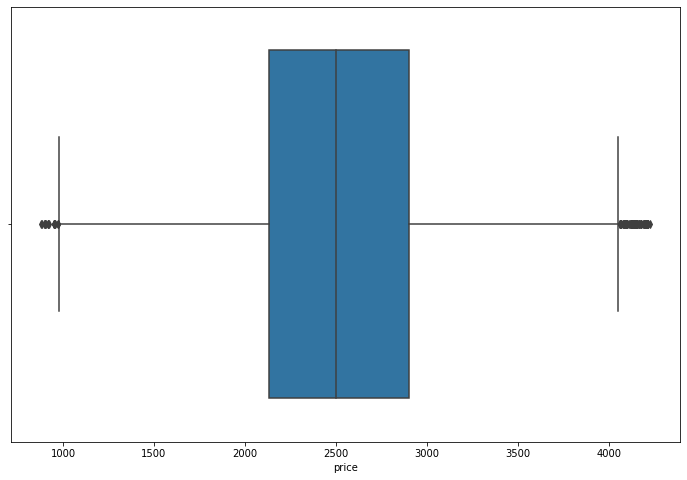

In [26]:
# show boxplot of price again
boxplot_with_y_var_and_hue(df, 'price', None, None, None)

In [30]:
# show
print('New dataset size')
len(df)

New dataset size


11977

### Notice how the distribution of rental price is still probably a bit skewed, but the outliers are far less extreme and disbursed. We can now readily proceed with some additional data cleaning and transformations to prep the data before running regressions.

## Final data cleaning and transformation steps before regression analysis:

### Specify a dictionary comprising each of the reference groups--namely, for the floorig types, housing/property types, parking options, and laundry options:

### NB: remove the indicator variables for each set that have the highest VIF. The main ones to concern ourselves with are: apt and washer_and_dryer (the other sets of indicator variables have fairly low VIF, so any can be removed without major multicollinearity consequences). 

In [31]:
# 
def specify_dict_of_reference_groups(**key_val_ref_group_col_names):
    return key_val_ref_group_col_names

dict_of_ref_group_col_names = specify_dict_of_reference_groups( flooring_type = 'flooring_carpet', housing_type = 'apt', 
laundry_indicators = 'washer_and_dryer', parking_options = 'no_parking') 

# sanity check
dict_of_ref_group_col_names

{'flooring_type': 'flooring_carpet',
 'housing_type': 'apt',
 'laundry_indicators': 'washer_and_dryer',
 'parking_options': 'no_parking'}

### Remove any columns that are clearly not relevant for regression analysis:

In [32]:
## 1) Remove cols that we will *not* use for regression analysis:

# remove these cols from dataset
def remove_non_regression_cols(df, list_of_non_OLS_cols):
    return df.drop(columns=list_of_non_OLS_cols)

# specify cols we will *not* use in the ression models:
non_OLS_cols = ["listing_id", "attr_vars", "date_of_webcrawler"] 


df = remove_non_regression_cols(df, non_OLS_cols)

# sanity check
print(f"{df.columns}")

Index(['sqft', 'city', 'price', 'bedrooms', 'bathrooms', 'kitchen',
       'date_posted', 'region', 'sub_region', 'cats_OK', 'dogs_OK',
       'wheelchair_accessible', 'laundry_in_bldg', 'washer_and_dryer',
       'washer_and_dryer_hookup', 'laundry_on_site', 'full_kitchen',
       'dishwasher', 'refrigerator', 'oven', 'flooring_carpet',
       'flooring_wood', 'flooring_tile', 'flooring_other', 'apt', 'in_law_apt',
       'condo', 'townhouse', 'cottage_or_cabin', 'single_fam', 'duplex',
       'flat', 'is_furnished', 'attached_garage', 'detached_garage', 'carport',
       'off_street_parking', 'no_parking', 'EV_charging', 'air_condition',
       'no_smoking', 'day_of_week', 'week', 'month', 'year', 'sqft_log'],
      dtype='object')


## 4) Split overall dataset into training & validation/test data:

In [33]:
#  4)  bifurcate dataset into train & test data
def split_to_train_and_test_data(df, outcome_var, test_size):
    X = df.drop(columns=outcome_var)  # specify RHS vars
    y = df[outcome_var]   # specify dependent variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=1)
    return X_train, X_test, y_train, y_test


# split overall dataset into 80% training & 20% validation
test_size = 0.2  # 20% validation/test
X_train, X_test, y_train, y_test = split_to_train_and_test_data(df, 'price', test_size)

# sanity check
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9581 entries, 7551 to 429
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sqft                     9581 non-null   int64         
 1   city                     9581 non-null   object        
 2   bedrooms                 9581 non-null   int64         
 3   bathrooms                9581 non-null   float64       
 4   kitchen                  9581 non-null   int64         
 5   date_posted              9581 non-null   datetime64[ns]
 6   region                   9581 non-null   object        
 7   sub_region               9581 non-null   object        
 8   cats_OK                  9581 non-null   int64         
 9   dogs_OK                  9581 non-null   int64         
 10  wheelchair_accessible    9581 non-null   int64         
 11  laundry_in_bldg          9581 non-null   int64         
 12  washer_and_dryer         9581 no

In [34]:
# remove original datatset, since we are now working with the training & test data
df = []

## Regression Analysis:

### Start with a Pooled OLS model--NB: use *all* available RHS variables, and use log sqft instead of untransformed sqft since multicollinearity would be slighly lower. 

In [40]:
## Fit Pooled OLS model via linearmodels library:

import statsmodels.api as sm
from linearmodels.panel import PooledOLS


def fit_Pooled_OLS(X_train, y_train, entity_effects, time_effects, outcome_var, irrelevant_cols_list, dict_of_ref_group_col_names, cov_type_option, cluster_entity_boolean):
    ## NB: we need to index the dataset along the entity and time (respectively) that we want for fixed/random effects:
    # 1st, we need to concat the X & y train data, since statsmodels' smf module requires we use the same dataset:
    df = pd.concat([y_train.rename(outcome_var), X_train], axis=1)  # rename y_train series to 'price' (ie, outcome variable) so we can later reference it when assigning the indexed X_train back to the y & X train objects

    #set index to the entity and time for transforming dataset to a proper panel 
    df = df.set_index([entity_effects, time_effects]) # set index to transform to panel dataset

    # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
    print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')

    # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
    # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
    list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings
    
    # a) remove each reference group col from dataset (ie, before running regression)
    df = df.drop(columns=list_of_ref_group_cols)

    #b) also, remove any irrelevant cols
    df = df.drop(columns=irrelevant_cols_list)  # remove irrelevant cols such as 'day_of_week'

    # From X_train dataset, obtain all RHS covariates --remove outcome var (NB: entity & time effects are set to the index, so no need to remove these):
    RHS = df.drop(columns = [outcome_var])  # remove outcome var

    # compute total number of all RHS variables (having *removed* the reference groups, entity+time effects, and irrelevant cols)   
    num_cols = RHS.shape[1]   # obtain number of  RHS cols
    print(f'The number of covariates (ie, RHS) is:\n{num_cols} columns') # print number of RHS covariates

    # add intercept (aka, constant) to RHS:
    RHS = sm.add_constant(RHS)


    # instantiate Pooled OLS model -- (NB: we cannot use entity effects or time effects since this is not a fixed, random, or mixed effects model)
    mod = PooledOLS(dependent = df[outcome_var], # specify dependent var data
                                exog = RHS # specify data for all covariate columns
                        )  

    # fit model --NB: use 'clustered' standard errors in a subsequent specification, *if* we later find the data have heteroskedasticity and autocorrelation issues, since it helps account for within-cluster correlations):
    if cov_type_option is not None:
        """Specify a covariance type option if we do not simply wish to bypass it altogether by using None."""
        pooled_res = mod.fit(cov_type= cov_type_option,    # NB*: set to 'cluster' for clustered stand errors
        cluster_entity= cluster_entity_boolean   # set to True if cluster standard errors are desired
        )
    
    else:  # ie: do *not* pass a custom covariance type option, so leave standard error estimation unadjusted
        pooled_res = mod.fit()

    # print results
    print(pooled_res)
    # return fitted Pooled OLS model res:
    return pooled_res

# fit Pooled OLS with city entity and week (over week) time effects, but leave standard errors unadjusted:

# specify entity and time cols for fixed effects
city_entity = "city"  #entity effect
# 
time_entity_week = "week"  # time effect

# specify outcome var name
outcome_var = "price"

# specify columns that are irrelevant (ie, not usable) to the regression model
# NB: remove sqft as well since we are using log of sqft
irrelevant_cols = ['sqft', 'date_posted', 'region', 'day_of_week', 'sub_region',  'year', 'month']

# specify standard error option-- NB: for purposes of Breush-Pagan test, simply use unadjusted stand errors
cov_type_option = None

# specify cluster standard error entity boolean
cluster_entity_boolean = False

# fit and return Pooled OLS model, with 
pooled_OLS_linearmodels = fit_Pooled_OLS(X_train, y_train, city_entity, time_entity_week, outcome_var, irrelevant_cols, dict_of_ref_group_col_names, cov_type_option, cluster_entity_boolean)

The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'washer_and_dryer', 'parking_options': 'no_parking'}
The number of covariates (ie, RHS) is:
32 columns
                          PooledOLS Estimation Summary                          
Dep. Variable:                  price   R-squared:                        0.2930
Estimator:                  PooledOLS   R-squared (Between):             -0.0076
No. Observations:                9581   R-squared (Within):               0.2970
Date:                Sun, Mar 20 2022   R-squared (Overall):              0.2930
Time:                        23:57:53   Log-likelihood                -7.346e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      123.67
Entities:                         100   P-value                           0.0000
Avg O

### Estimate Random Effects model:

In [42]:
## Estimate a Random Effects model

from linearmodels.panel import RandomEffects


def fit_Random_Effects(X_train, y_train, entity_effects, time_effects, outcome_var, irrelevant_cols_list, dict_of_ref_group_col_names, cov_type_option, cluster_entity_boolean):
    ## NB: we need to index the dataset along the entity and time (respectively) that we want for fixed/random effects:
    # 1st, we need to concat the X & y train data, since statsmodels' smf module requires we use the same dataset:
    df = pd.concat([y_train.rename(outcome_var), X_train], axis=1)  # rename y_train series to 'price' (ie, outcome variable) so we can later reference it when assigning the indexed X_train back to the y & X train objects

    #set index to the entity and time for transforming dataset to a proper panel 
    df = df.set_index([entity_effects, time_effects]) # set index to transform to panel dataset

    # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
    print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')

    # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
    # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
    list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings
    
    # a) remove each reference group col from dataset (ie, before running regression)
    df = df.drop(columns=list_of_ref_group_cols)

    #b) also, remove any irrelevant cols
    df = df.drop(columns=irrelevant_cols_list)  # remove irrelevant cols such as 'day_of_week'

    # From X_train dataset, obtain all RHS covariates --remove outcome var (NB: entity & time effects are set to the index, so no need to remove these):
    RHS = df.drop(columns = [outcome_var])  # remove outcome var

    # compute total number of all RHS variables (having *removed* the reference groups, entity+time effects, and irrelevant cols)   
    num_cols = RHS.shape[1]   # obtain number of  RHS cols
    print(f'The number of covariates (ie, RHS) is:\n{num_cols} columns') # print number of RHS covariates

    # add intercept (aka, constant) to RHS:
    RHS = sm.add_constant(RHS)



    # instantiate Panel regression model , and specify as arguments whether to use entity effects or time effects
    mod = RandomEffects(dependent = df[outcome_var], # specify dependent var data
    exog = RHS, # specify data for all covariate columns    
    )  

    # fit model --NB: use 'clustered' standard errors in a subsequent specification, *if* we later find the data have heteroskedasticity and autocorrelation issues, since it helps account for within-cluster correlations):
    if cov_type_option is not None:
        """Specify a covariance type option if we do not simply wish to bypass it altogether by using None."""
        random_effects_fitted = mod.fit(cov_type= cov_type_option,    # NB*: set to 'cluster' for clustered stand errors
        cluster_entity= cluster_entity_boolean   # set to True if cluster standard errors are desired
        )
    
    else:  # ie: do *not* pass a custom covariance type option, so leave standard error estimation unadjusted
        random_effects_fitted = mod.fit()
        
    

    # print results
    print(random_effects_fitted)
    # return fitted Pooled OLS model res:
    return random_effects_fitted



# fit Random Effects with city entity and week (over week) time effects, but leave standard errors unadjusted:

# specify entity and time cols for fixed effects
city_entity = "city"  #entity effect
# 
time_entity_week = "week"  # time effect

# specify outcome var name
outcome_var = "price"

# specify columns that are irrelevant (ie, not usable) to the regression model
irrelevant_cols = ['sqft', 'date_posted', 'region', 'day_of_week', 'sub_region',  'year', 'month']

# specify to include the time entities
time_effects_boolean = True

# specify standard error option-- NB: for purposes of Breush-Pagan test, simply use unadjusted stand errors
cov_type_option = None

# specify cluster standard error entity boolean
cluster_entity_boolean = False

# fit and return Pooled OLS model, with 
random_effects_unadjusted = fit_Random_Effects(X_train, y_train, city_entity, time_entity_week, outcome_var, irrelevant_cols, dict_of_ref_group_col_names, cov_type_option, cluster_entity_boolean)

The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'washer_and_dryer', 'parking_options': 'no_parking'}
The number of covariates (ie, RHS) is:
32 columns
                        RandomEffects Estimation Summary                        
Dep. Variable:                  price   R-squared:                        0.3944
Estimator:              RandomEffects   R-squared (Between):             -0.0045
No. Observations:                9581   R-squared (Within):               0.3181
Date:                Mon, Mar 21 2022   R-squared (Overall):              0.2550
Time:                        00:20:12   Log-likelihood                -7.247e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      194.32
Entities:                         100   P-value                           0.0000
Avg O

## Estimate Fixed Effects (unadjusted SE)

In [43]:
import statsmodels.api as sm

from linearmodels.panel import PanelOLS


def fit_Fixed_Effects(X_train, y_train, outcome_var, entity_effects, time_effects, irrelevant_cols_list, dict_of_ref_group_col_names, entity_effects_boolean, time_effects_boolean, cluster_SE_boolean):
  ## NB: we need to index the dataset along the entity and time (respectively) that we want for fixed/random effects:
  # 1st, we need to concat the X & y data, for purposes of setting the index:
  df = pd.concat([y_train.rename(outcome_var), X_train], axis=1)  # rename y_train series to 'price' (ie, outcome variable) so we can later reference it when assigning the indexed df back to the y & X train objects

  #set index to the entity and time for transforming dataset to a proper panel
  df = df.set_index([entity_effects, time_effects]) # set index to transform to panel dataset

  # # re-assign the indexed dataset back to y & X train:
  y_train, X_train = df[outcome_var], df.drop(columns=[outcome_var])

  # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
  print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')

  # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
  # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
  list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings

  # a) remove each reference group col from dataset (ie, before running regression)
  X_train = X_train.drop(columns=list_of_ref_group_cols)


  #b) also, remove any irrelevant cols
  X_train = X_train.drop(columns=irrelevant_cols_list)  # remove irrelevant cols such as 'day_of_week'

  # compute total number of all RHS variables (having *removed* the reference groups, entity+time effects, and irrelevant cols)
  num_cols = X_train.shape[1]   # obtain number of  X_train cols
  print(f'\nThe number of covariates (ie, X_train) is:\n{num_cols} columns\n\n') # print number of X_train covariates

  # add intercept (aka, constant) to X_train:
  X_train = sm.add_constant(X_train)

  # instantiate Panel regression model , and specify as arguments whether to use entity effects or time effects
  mod = PanelOLS(dependent = y_train, # specify dependent var data
                              exog = X_train, # specify data for all covariate columns,
                              entity_effects= entity_effects_boolean,  # ie, whether to include entity effects
                              time_effects= time_effects_boolean   # whether to include time effects
                  )


  if cluster_SE_boolean is True:
    # fit model using clustered (adjusted) standard errors:
    fixed_effects_fitted = mod.fit(cov_type='clustered', cluster_entity=True)

  else:
    # fit model, using unadjusted standard errors:
    fixed_effects_fitted = mod.fit() # leave SE unadjusted

  # print results
  print(f'Regression results:\n{fixed_effects_fitted.summary}')
  # return fitted fixed effects model results
  return fixed_effects_fitted

## Estimate Fixed Effects model with city entity effects and week time effects

# specify outcome variable
outcome_var = 'price'

# specify entity and time cols for fixed effects
city_entity = "city"  #entity effect
# tim effect
time_entity_week = "week"  # time effect

# specify columns that are irrelevant (ie, not usable) to the regression model
irrelevant_cols = ['sqft', 'date_posted', 'region', 'day_of_week', 'sub_region',  'year', 'month']

## specify boolean values for whether we want entity effects & time effects, respectively
# NB: we want *both* entity effects & time effects, so set both to True
entity_effects_boolean, time_effects_boolean = True, True

# specify as True or false whether we want to cluster the standard errors:
# use False here , since we want *unadjusted* standard errors
cluster_SE_boolean = False
  
fixed_effects_unadjusted = fit_Fixed_Effects(X_train, y_train, outcome_var, city_entity, time_entity_week, irrelevant_cols, dict_of_ref_group_col_names, entity_effects_boolean, time_effects_boolean, cluster_SE_boolean)

The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'washer_and_dryer', 'parking_options': 'no_parking'}

The number of covariates (ie, X_train) is:
32 columns


Regression results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.3187
Estimator:                   PanelOLS   R-squared (Between):             -0.0806
No. Observations:                9581   R-squared (Within):               0.3181
Date:                Mon, Mar 21 2022   R-squared (Overall):              0.2691
Time:                        00:20:30   Log-likelihood                -7.237e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      137.77
Entities:                         100   P-value            

### Fit a Fixed Effects with clustered SE:

In [44]:
## Fit fixed effects model with clustered SE:

# specify as True since we want to cluster the standard errors:
cluster_SE_boolean = True

fixed_effects_clustured_SE = fit_Fixed_Effects(X_train, y_train, outcome_var, city_entity, time_entity_week, irrelevant_cols, dict_of_ref_group_col_names, entity_effects_boolean, time_effects_boolean, cluster_SE_boolean)

The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'washer_and_dryer', 'parking_options': 'no_parking'}

The number of covariates (ie, X_train) is:
32 columns


Regression results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.3187
Estimator:                   PanelOLS   R-squared (Between):             -0.0806
No. Observations:                9581   R-squared (Within):               0.3181
Date:                Mon, Mar 21 2022   R-squared (Overall):              0.2691
Time:                        00:20:57   Log-likelihood                -7.237e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      137.77
Entities:                         100   P-value            

### Compare regression results using linearmodels.panel's compare method:

In [45]:
from linearmodels.panel import compare

def compare_fitted_panel_models_lm(pooled_OLS, fixed_unadjusted, fixed_clustered, random_effects):
    # NB: use stars =True argument so we can print out stars denoting signicance levels:
    print(compare({"Pooled_OLS": pooled_OLS, "Fixed_effects": fixed_unadjusted, "Fixed_effects_clustered_SE": fixed_clustered, "Random_Effects": random_effects},
    stars=True))


compare_fitted_panel_models_lm(pooled_OLS_linearmodels, fixed_effects_unadjusted, fixed_effects_clustured_SE, random_effects_unadjusted)

                                           Model Comparison                                           
                                Pooled_OLS  Fixed_effects Fixed_effects_clustered_SE    Random_Effects
------------------------------------------------------------------------------------------------------
Dep. Variable                        price          price                      price             price
Estimator                        PooledOLS       PanelOLS                   PanelOLS     RandomEffects
No. Observations                      9581           9581                       9581              9581
Cov. Est.                       Unadjusted     Unadjusted                  Clustered        Unadjusted
R-squared                           0.2930         0.3187                     0.3187            0.3944
R-Squared (Within)                  0.2970         0.3181                     0.3181            0.3181
R-Squared (Between)                -0.0076        -0.0806                

## Interpreting Regression Results:

#### First, note that the sample size is moderately lower than the ~13,000 we used for the first data analysis notebook: about 26% lower (9,581), given we removed price outliers using a *broader* criteria of IQR * 1.5 as opposed to removing only extreme outliers. In addition, we also removed at least several hundred records in this Part 2 analysis in order to remove sqft outliers that were very likely due to data entry errors.  

#### NB: For reference, refer to 'Panel_regressions_res_sqft_and_1.5_IQR_price_outliers_removed_SFBay_craigslist_rental_Oct_2021_to_Mar_10_.txt', saved in the regression_models subdirectory. 

#### In terms of regression results, notice that the coefficients for many of the variables are quite smaller in magnitude than for most of the regression results that we saw in the Part 1 analysis. This is especially true for quite substantially staistically significant variables such as bathrooms, flat, and detached as well as attached garage, and also bedrooms to a lesser extent.

#### These generally smaller magnitudes are very likely due to having removed a larger portion of the outliers from the dataset, which resulted in lower sample average rental prices and a far less pronounced positively-skewed distribution of rental prices. 

#### The log of sqft coefficient is also highly significant and fairly high in magnitude in all of the panel regression models, which is in accordance with our expectations since basic economics would hypothesize that larger average rental home sizes would command higher average rental prices. 

#### Somewhat surprisingly, the R2 values--including the Within R2 that we are most interested in (since this reflects goodness-of-fit with respect to each individual city-level value)--are moderately lower than that of the Part 1 notebook's regression models. This suggests that some of the rental price outliers were actually being explained fairly effectively by variables such as log of sqft, bedrooms, and bathrooms. 

#### While many of the same variables are still statistically significant--such as log sqft, bedrooms, a few of the home type variables such as flat, bathrooms, and non smoking--none of the flooring type indicator variables (such as wood flooring type) are even remotely significant. Property types such as flat (especially) and single family homes to a lesser extent are the most expensive rental home types. 

#### Overall, the most important factors in affecting rental prices tend to be a mixture of the following variables: a) a larger number of bedrooms (especially) or bathrooms; b) higher sqft; c) having a rental with an Electric Vehicle charger (a higher rental price boost than even having an additional bathroom); d) having an attached or especially a detached garage (likely an even bigger spike in rental price compare with an EV charger); e) having a non-smoking rental property; and having a single family home or especially a flat home type. Of *all* variables, having a flat home type increases average rental prices more than any other single factor, on the margin. For example, on the margin, adding an additional bedroom and an additional full bathroom to an apartment rental listing is still somewhat less expensive than renting a flat, on average!    

### Obtain coefficients and var names from the fitted model!!

In [47]:
## Derive in-sample predictions with the training data , using the *fitted* Fixed Effects model with all RHS vars, & all extreme outliers removed from dataset:
import statsmodels.api as sm

from linearmodels.panel import PanelOLS


def derive_prediction_with_fitted_Fixed_Effects_lm(fitted_model, X_data, y_data, outcome_var, entity_effects, time_effects, irrelevant_cols_list, dict_of_ref_group_col_names, entity_effects_boolean):
    """
    Take input of fitted Fixed Effects model, using linearmodels library.
    Use .predict() to make prediction using test data. Set index to entity & time effects to make .predict() work with the fitted model object."""
    ## NB: we need to index the dataset along the entity and time (respectively) that we want for fixed/random effects:
    # a) 1st, we need to concat the X & y data, for purposes of setting the index:
    df = pd.concat([y_data.rename(outcome_var), X_data], axis=1)  # rename y_data series to 'price' (ie, outcome variable) so we can later reference it when assigning the indexed df back to the y & X train objects

    # b) set index to the entity and time for transforming dataset to a proper panel
    df = df.set_index([entity_effects, time_effects]) # set index to transform to panel dataset

    # # c) re-assign the indexed dataset back to y & X train:
    y_data, X_data = df[outcome_var], df.drop(columns=[outcome_var])  

    # NB!: specify the names of the reference group columns for the sets of mutually exclusive indicator variables--e.g., the housing type indicators (ie, apt, duplex, etc.)
    print(f'The reference groups for the sets of mutually exclusive indicator variables are:\n{ {key:value for key, value in dict_of_ref_group_col_names.items()} }')

    # NB2: remove all reference groups for the sets of mutually exclusive indicator variables
    # for ease of removing reference group cols, convert the dictionary's values to a list of str elements:
    list_of_ref_group_cols = [str(value) for key, value in dict_of_ref_group_col_names.items()] # convert the values (ie, the column names) of the dict to a list of strings

    # a) remove each reference group col from dataset (ie, before running regression)
    X_data = X_data.drop(columns=list_of_ref_group_cols)


    #b) also, remove any irrelevant cols
    X_data = X_data.drop(columns=irrelevant_cols_list)  # remove irrelevant cols such as 'day_of_week'

    # compute total number of all RHS variables (having *removed* the reference groups, entity+time effects, and irrelevant cols)
    num_cols = X_data.shape[1]   # obtain number of  X_data cols
    print(f'\nThe number of covariates (ie, X_data) is:\n{num_cols} columns\n\n') # print number of X_data covariates

    # add intercept (aka, constant) to X_data:
    X_data = sm.add_constant(X_data)

    # derive predictions with test data, using fitted regression
    model_predictions = fitted_model.predict(X_data)


    # print results
    print(f'Regression predictions:\n{model_predictions}')
    # return fitted fixed effects model results
    return model_predictions

## Specify arguments, and make predictions using fitted regression model with city entity effects and week time effects

# specify outcome variable
outcome_var = 'price'

# specify entity and time cols for fixed effects
city_entity = "city"  #entity effect
# tim effect
time_entity_week = "week"  # time effect

# specify columns that are irrelevant (ie, not usable) to the regression model
# NB!: remove sqft since we want to use log of sqft instead:
irrelevant_cols = ['sqft', 'sub_region', 'date_posted', 'region', 'day_of_week', 'year', 'month']

## specify boolean value for whether we are using a fitted Fixed Effects model that had entity effects
entity_effects_boolean = True


## Make predictions based on training data

FE_train_preds = derive_prediction_with_fitted_Fixed_Effects_lm(fixed_effects_unadjusted, X_train, y_train, outcome_var, city_entity,  time_entity_week, irrelevant_cols, dict_of_ref_group_col_names, entity_effects_boolean)
# sanity check
FE_train_preds

The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'washer_and_dryer', 'parking_options': 'no_parking'}

The number of covariates (ie, X_data) is:
32 columns


Regression predictions:
                    predictions
city          week             
Fremont       2     2105.880889
San Francisco 49    1838.421875
Aptos         49    2697.600106
San Jose      9     2723.245210
Oakland       52    2322.142052
...                         ...
Hayward       5     2820.357282
Santa Clara   8     3245.208950
Santa Rosa    44    2555.972263
Dublin        2     2207.423547
Daly City     41    2154.831619

[9581 rows x 1 columns]


,,predictions
city,week,
Fremont,2,2105.880889
San Francisco,49,1838.421875
Aptos,49,2697.600106
San Jose,9,2723.245210
Oakland,52,2322.142052
...,...,...
Hayward,5,2820.357282
Santa Clara,8,3245.208950
Santa Rosa,44,2555.972263


### Derive predictions using the test data

In [48]:
## Derive predictions with the *test* data (ie, essentially an out-of-sample prediction), using the *fitted* Fixed Effects model (ie, the model with all RHS vars & all extreme outliers removed from dataset):
## Derive in-sample predictions with the training data , using the *fitted* Fixed Effects model with all RHS vars, & all extreme outliers removed from dataset:
import statsmodels.api as sm

from linearmodels.panel import PanelOLS


## Estimate Fixed Effects model with city entity effects and week time effects

# specify outcome variable
outcome_var = 'price'

# specify entity and time cols for fixed effects
city_entity = "city"  #entity effect
# tim effect
time_entity_week = "week"  # time effect

# specify columns that are irrelevant (ie, not usable) to the regression model
# NB!: remove sqft since we want to use log of sqft instead:
irrelevant_cols = ['sqft', 'sub_region', 'date_posted', 'region', 'day_of_week', 'year', 'month']

## specify boolean value for whether we are using a fitted Fixed Effects model that had entity effects
entity_effects_boolean = True


## Make predictions based on *test* data

FE_test_preds = derive_prediction_with_fitted_Fixed_Effects_lm(fixed_effects_unadjusted, X_test, y_test, outcome_var, city_entity,  time_entity_week, irrelevant_cols, dict_of_ref_group_col_names, entity_effects_boolean)
# sanity check
FE_test_preds

The reference groups for the sets of mutually exclusive indicator variables are:
{'flooring_type': 'flooring_carpet', 'housing_type': 'apt', 'laundry_indicators': 'washer_and_dryer', 'parking_options': 'no_parking'}

The number of covariates (ie, X_data) is:
32 columns


Regression predictions:
                    predictions
city          week             
San Mateo     47    2603.382252
Mountain View 44    1962.758757
San Francisco 50    2128.014741
Oakland       8     2936.244682
Novato        44    2444.927588
...                         ...
Palo Alto     49    3247.036512
Fremont       9     2126.274065
Mountain View 4     3010.767616
Berkeley      6     2619.522371
Fremont       50    1997.244653

[2396 rows x 1 columns]


,,predictions
city,week,
San Mateo,47,2603.382252
Mountain View,44,1962.758757
San Francisco,50,2128.014741
Oakland,8,2936.244682
Novato,44,2444.927588
...,...,...
Palo Alto,49,3247.036512
Fremont,9,2126.274065
Mountain View,4,3010.767616


## Visualize Fixed Effects model predictions:

### Plot residuals vs actual, and Predicte vs Actual

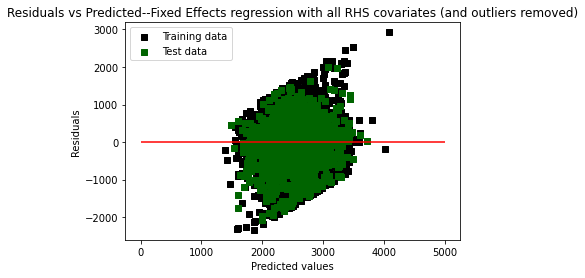

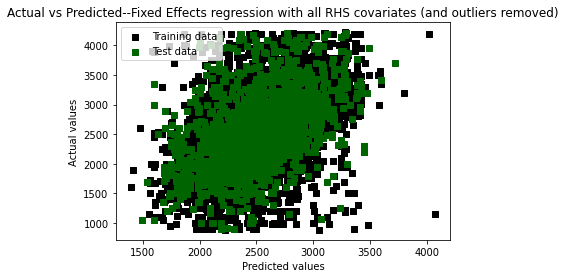

In [68]:
## Plot training vs test data predictions of Fixed Effects model (ie, with all available RHS's and extreme outliers removed):

def plot_training_vs_test_predictions_and_residuals(train_preds, test_preds, y_train, y_test):
    """"Scatterplot comparing test vs training data predictions as well as residuals. Requires fitted regression model predictions & the original train and test outcome variable datasets as inputs"""

    # # Look at predictions on training and validation set
    # print("RMSE on Training set :", rmse_cv_train(lr).mean())
    # print("RMSE on Test set :", rmse_cv_test(lr).mean())

    ## NB: clean linearmodels' predictions: a) reset index (and remove index) & b) get just the predictions Series (col) data
    # clean training prediction data
    train_preds =  train_preds.reset_index(drop=True).predictions # reset index, and get just the predictions data

    # clean test predictions
    test_preds =  test_preds.reset_index(drop=True).predictions # reset index, and get just the predictions data

    # ## NB: we need to reset the index for y train & test data, respectively, so we can calculate residuals without index issues
    
    # calculate residuals--train data
    train_residuals = train_preds - y_train.reset_index(drop=True)  # reset index for y_train, and calculate residuals wrt train data

    # residuals--test data 
    test_residuals = test_preds - y_test.reset_index(drop=True)  # reset index for y_test, and calculate residuals wrt test data

    # # Plot residuals
    plt.scatter(train_preds, train_residuals, c = "black", marker = "s", label = "Training data")
    plt.scatter(test_preds, test_residuals, c = "darkgreen", marker = "s", label = "Test data")
    plt.title("Residuals vs Predicted--Fixed Effects regression with all RHS covariates (and outliers removed)")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 0, xmax = 5000, color = "red")
    
    # x_range = np.linspace(X.min(), X.max(), 100)
    # y_range = model.predict(x_range.reshape(-1, 1))

    plt.show()

    ## Plot Actual vs Predicted
    plt.scatter(train_preds, y_train, c = "black", marker = "s", label = "Training data")
    plt.scatter(test_preds, y_test, c = "darkgreen", marker = "s", label = "Test data")
    plt.title("Actual vs Predicted--Fixed Effects regression with all RHS covariates (and outliers removed)")
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.legend(loc = "upper left")
    plt.show()


plot_training_vs_test_predictions_and_residuals(FE_train_preds, FE_test_preds, y_train, y_test)

### To give more context for the distribution of test residuals, let's examine a  boxplot of residuals: 

In [81]:
# residuals of FE model wrt test data 
test_residuals = FE_test_preds.reset_index(drop=True).predictions - y_test.reset_index(drop=True)  # reset index for y_test, and calculate residuals wrt test data

# transform to df, and rename col:
test_residuals = pd.DataFrame(test_residuals)

test_residuals.columns = ['residuals']
#sanity check
test_residuals

,residuals
0,-802.617748
1,-187.241243
2,328.014741
3,-260.755318
4,-604.072412
...,...
2391,-651.963488
2392,176.274065
2393,-224.232384
2394,17.522371


<AxesSubplot:xlabel='residuals'>

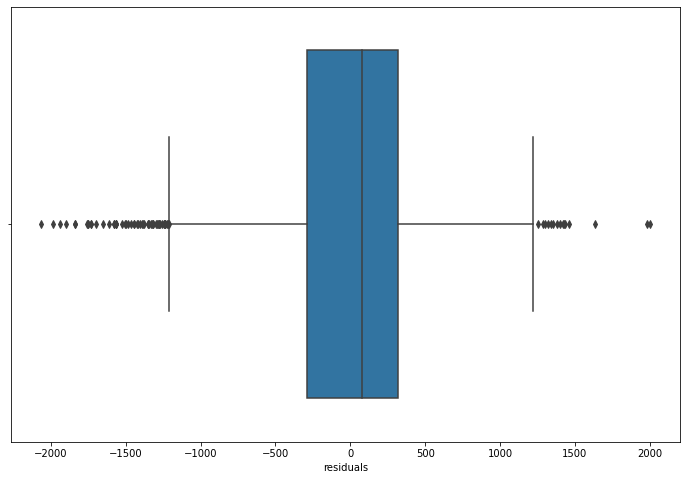

In [82]:
# boxplot of residuals wrt test data
boxplot_with_y_var_and_hue(test_residuals, 'residuals', None, None, None)

In [85]:
# print mean, median, and stand dev of residuals
print("Mean, median, and standard deviation of residuals:")
print(test_residuals.mean())
print(test_residuals.median())
print(test_residuals.std())

Mean, median, and standard deviation of residuals:
residuals   -3.707087
dtype: float64
residuals    75.147794
dtype: float64
residuals    517.288027
dtype: float64


### We can see that our predictions still aren't especially good, although the test data predictions seem to be a bit more precise than in the Part 1 analysis.

### In addition, while there is no obvious pattern to the residuals, variance does seem to be fairly higher on both extremes of the distirbution. Namely, residuals tend to be highest for the lowest predicted values as well as the highest predicted values. 

### As a result, our model predicted relatively well along values that are fairly close the sample mean, but the predictions tend to be quite a bit less accurate along either the smallest or largest values. 

#### The boxplot gives us some extra context for this since there are clearly many rather large outliers. While there are large outliers along both sides of the distribution, it appears that the Fixed Effects model might have under-estimated the true values by large amounts (ie, constituing outliers) a bit more frequently than it overestimated values. The worst residuals over or under-predicted the true values by up to $2,000!

#### The median of the test residuals--$75--is somewhat higher than the mean of -$3, indicating the distribution is somewhat negatively skewed. The standard deviation, however, is fairly high, at $517, implying that the Fixed Effects models' predications are fairly inconsistent at predicting the true rental prices. However, given the residual plot, we can tell that the best predictions are those residing near the mean, with small and large rental prices being harder for the model to predict.   


### Let's now quantify predictive accuracy via RMSE & SI (scatter index):

### RMSE for training data:

In [53]:
# Determine accuracy of models by calculating root-mean squared error (ie, RMSE)
def calc_RMSE_linearmodels(fitted_reg_model):
    """ NB: We will assume we are using the linearmodels library or other libraries
    that enable us to use a .resids method to calculate a fitted regression's residuals. """
    # derive the residuals --ie, diff b/w regression predictions & the true/actual values, and then sample size
    residuals = fitted_reg_model.resids
    sample_size = len(residuals) # calculate sample size vis-a-vis number of residuals derived by the model 
    # calculate RMSE
    RMSE = np.linalg.norm(residuals)/np.sqrt(sample_size)
    # NB: if we were using a separate library for regression analysis, we could instead use the following to calculate RMSE:
    # RMSE = np.linalg.norm(reg_model_preds - y_test_data)/np.sqrt(sample_size) # calculate RMSE
    return RMSE

# a) for *training* dataset: calculate RMSE for the Fixed Effects model ):
RMSE_FE_train = calc_RMSE_linearmodels(fixed_effects_unadjusted)



def calc_Scatter_Index(RMSE, y_data):
    return RMSE/y_data.mean()  # calculate SI by normalizing RMSE via the sample mean of the outcome var test data 

# a) for train data: calculate SI for the Fixed Effects model, using training data as reference
SI_FE_train = calc_Scatter_Index(RMSE_FE_train, y_train)



# print RMSE & SI:
def print_RMSE_and_SI(reg_model_type:str, train_or_test_data_str:str, RMSE:float, SI:float):
    print(f'\nRMSE of the {reg_model_type} model on the {train_or_test_data_str}:\n{RMSE}\n, and the corresponding scatter index (SI):\n{SI}')

# print vals for train data Fixed Effects
print_RMSE_and_SI('fixed_effects_unadjusted', 'training data', RMSE_FE_train, SI_FE_train)


RMSE of the fixed_effects_unadjusted model on the training data:
461.50891864636236
, and the corresponding scatter index (SI):
0.18145591992902158


### RMSE for test data

In [58]:
## b) Calculate RMSE for *test* dataset--
## NB: we need to *first* estiamte the residuals since we obv did not fit the model using test data
def calc_residuals_and_RMSE_test_data(predictions_from_fitted_reg, y_data):
    # NB: reset index of fitted models' predictions, and get the 'predictions' col as a Series
    predictions_from_fitted_reg   =  predictions_from_fitted_reg.reset_index(drop=True).predictions

    # ## NB: we need to reset the index for y train & test data, respectively, so we can calculate residuals without index issues
    # calculate residuals:
    residuals = predictions_from_fitted_reg - y_data.reset_index(drop=True)

    sample_size = len(residuals) # calculate sample size vis-a-vis number of residuals derived by the model 
    # calculate RMSE
    RMSE = np.linalg.norm(residuals)/np.sqrt(sample_size)
    return RMSE

RMSE_FE_test = calc_residuals_and_RMSE_test_data(FE_test_preds, y_test)

## b) for test data: calculate SI for the Fixed Effects model, using testing data as reference

SI_FE_test = calc_Scatter_Index(RMSE_FE_test, y_test)

# print vals for test data
print_RMSE_and_SI('fixed_effects_unadjusted', 'test data', RMSE_FE_test, SI_FE_test)


RMSE of the fixed_effects_unadjusted model on the test data:
517.1933537440113
, and the corresponding scatter index (SI):
0.2034502074685574


## Analyzing and comparing RMSE & SI for Part 1 vs Part 2:

### Even though the R2 values for each of the panel regression models were lower in Part 2 than that of the regression models fitted in the Part 1 analysis, both RMSE and SI are somewhat lower for the models in this Part 2 analysis. 

### For example, the best SI in the Part 1 models --which was achieved after removing extreme price outliers--was 23.2%. 

### By contrast, the models estimated here in Part 2 indicate a Scatter Index of 18.1% with respect to the training data and an SI of 20.3% for the test data. Thus, while the estimates of the panel regressions are still not terribly accurate, we've clearly achieved moderate improvements in predictive accuracy. Also, since the SI for test data is not too much higher than that of the training data, the regression model appears to be at least not over-fitting or sepecially under-fitting the data, albeit not fit to the data especially well. 

### In short, removing sqft and price outliers has moderately improved the predictive performance of the panel regression models. Given how volatile and messy the original scraped rental price data can be, this analysis has shown that we can still obtain some amount of signal and predictive power in spite of the noise. 

## NB: When we *have scraped* enough *new* data via the webcrawler--ie, after March 11, 2021--we should save the data to the SQL rental table via the CSV file to SQL Server data pipeline, and import the newer data to derive *out-of-sample* regression predictions. NB: verify this by filtering based on being > the MAX() date of the data that we used to train the regression model--ie, March 11, 2021!